In [1]:
from desc.compute.utils import get_transforms, get_profiles, get_params, dot
from desc.compute import compute as compute_fun
from desc.backend import jnp
from desc.grid import Grid, LinearGrid
import desc.io
import desc.examples
from functools import partial
from jax import jit
from jax.experimental.ode import odeint as jax_odeint
import matplotlib.pyplot as plt
import numpy as np
import time

# eq = desc.examples.get("DSHAPE")
eq = desc.io.load("equilibria/test_run.h5")
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.solve()

def B_for_f_ratio_surface(psi_i):
    grid = LinearGrid(rho = np.sqrt(psi_i), M = 20, N = 20, NFP = eq.NFP)
    output = eq.compute("|B|", grid=grid)
    B = output["|B|"]
    return B

def B_for_f_ratio_fieldline(psi_i):
    coords = jnp.ones((250, 3)) #rho alpha zeta
    coords = coords.at[:, 0].set(coords[:, 0] * jnp.sqrt(psi_i))
    coords = coords.at[:, 2].set(jnp.linspace(0, 6 * jnp.pi, 250))

    start_time = time.time()
    print("starting map coords")
    print("--- %s seconds ---" % (time.time() - start_time))

    coords1 = eq.map_coordinates(
        coords=coords,
        inbasis=["rho", "alpha", "zeta"],
        outbasis=["rho", "theta", "zeta"],
        period=[jnp.inf, 2 * jnp.pi, jnp.inf],
        guess=None,
    )  # (2 * jnp.pi / eq.NFP)],

    grid = Grid(coords1, jitable=False, sort=False)
    output = eq.compute("|B|", grid=grid)

    B = output["|B|"]
    return B, coords1

def f_ratio(B):
    return np.sqrt(1-np.nanmin(B)/np.nanmax(B))




DESC version 0+untagged.5510.g707828e,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 3.21 GB available memory
Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 856
Number of objectives: 5346
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 2.734e-06
         Total delta_x: 6.469e-02
         Iterations: 5
         Function evaluations: 9
         Jacobian evaluations: 6
Start of solver
Total (sum of squares):  2.876e-06, 
Total force:  1.355e+05 (N)
Total force:  2.398e-03 (normalized)
End of solver
Total (sum of squares):  2.734e-06, 
Total force:  1.321e+05 (N)
Total force:  2.338e-03 (normalized)


In [2]:
def check(quantity, rho_i, theta_i, zeta_i):
    grid = Grid(jnp.array([rho_i, theta_i, zeta_i]).T, jitable=True, sort=False)
    output = eq.compute(quantity, grid=grid)
    return output[quantity]

# plot_3d(eq, "B")
val = check("grad(psi)", 1, 0, 0)[0]
print(val)

[ 1.57992279e+01 -3.24372694e-16  7.48118656e-16]


In [3]:
def system(w, t, a):
    #initial conditions
    psi, theta, zeta, vpar = w
    
    keys = ["B", "|B|", "grad(|B|)", "grad(psi)", "e^theta", "e^zeta", "b", "psidot", "thetadot", "zetadot", "vpardot"] # etc etc, whatever terms you need
    grid = Grid(jnp.array([jnp.sqrt(psi), theta, zeta]).T, jitable=True, sort=False)
    transforms = get_transforms(keys, eq, grid, jitable=True)
    profiles = get_profiles(keys, eq, grid, jitable=True)
    params = get_params(keys, eq)
    data = compute_fun(eq, keys, params, transforms, profiles, mu = a[0], vpar = vpar, m_q = a[1])
    

    psidot = data["psidot"]
    thetadot = data["thetadot"]
    zetadot = data["zetadot"]
    vpardot = data["vpardot"]

    print(psidot)

    return jnp.array([psidot, thetadot, zetadot, vpardot])

In [4]:
def run(E_, q_, bound_psi, m_, t_i, t_f, nt_ ,psi_i, theta_i, zeta_i, vpar_i_ratio):
    e_charge = q_*1.6e-19
    m = m_*1.673e-27
    tmin = t_i
    tmax = t_f
    nt = nt_
    E = E_*3.52e6*e_charge
    m_q = m/e_charge

    v_parallel = vpar_i_ratio*jnp.sqrt(2*E/m)
    
    grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
    data = eq.compute("|B|", grid=grid)

    mu = E/(m*data["|B|"]) - (v_parallel**2)/(2*data["|B|"])
    a_initial = [float(mu), m_q, bound_psi]
    initial_conditions = [psi_i, theta_i, zeta_i, v_parallel]
    print(a_initial)

    def solve_with_jax(a=None):
        initial_conditions_jax = jnp.array(initial_conditions, dtype=jnp.float64)
        a_jax = jnp.array(a_initial, dtype=jnp.float64)
        t_jax = jnp.linspace(tmin, tmax, nt)
        system_jit = jit(system)
        solution_jax = jax_odeint(partial(system_jit, a=a_jax), initial_conditions_jax, t_jax)
        return solution_jax
    
    sol = solve_with_jax()
    print(sol)

    return sol, mu

In [5]:
E_ = 1
q_= 1
m_ = 1
t_i = 0 
t_f = 0.00007
nt_ = 200

psi_i = 0.7
theta_i = 0.2
zeta_i = 0.2
bound_psi = check("psi", 1, theta_i, zeta_i)[0]

f = f_ratio(B_for_f_ratio_surface(psi_i=psi_i))

print(psi_i, theta_i, zeta_i)

vpar_i_ratio = 0.7*f
sol, mu = run(E_, q_, bound_psi, m_, t_i, t_f, nt_, psi_i, theta_i, zeta_i, vpar_i_ratio)

0.7 0.2 0.2
0.24074592089559968
[63419741148794.98, 1.0456250000000001e-08, 7.736976778455998]
Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace(level=2/0)>


2023-09-05 16:36:05.047820: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-09-05 16:37:31.975051: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m26.927356003s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


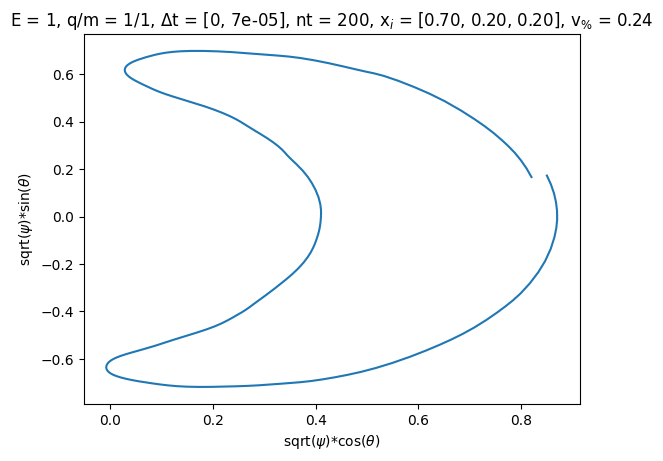

In [ ]:
plt.plot(np.sqrt(sol[:, 0]) * np.cos(sol[:, 1]), np.sqrt(sol[:, 0]) * np.sin(sol[:, 1]))
plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.title(rf'E = {E_}, q/m = {q_}/{m_}, $\Delta$t = [{t_i}, {t_f}], nt = {nt_}, x$_i$ = [{psi_i:.2f}, {theta_i:.2f}, {zeta_i:.2f}], v$_\%$ = {vpar_i_ratio:.2f}')
plt.show()

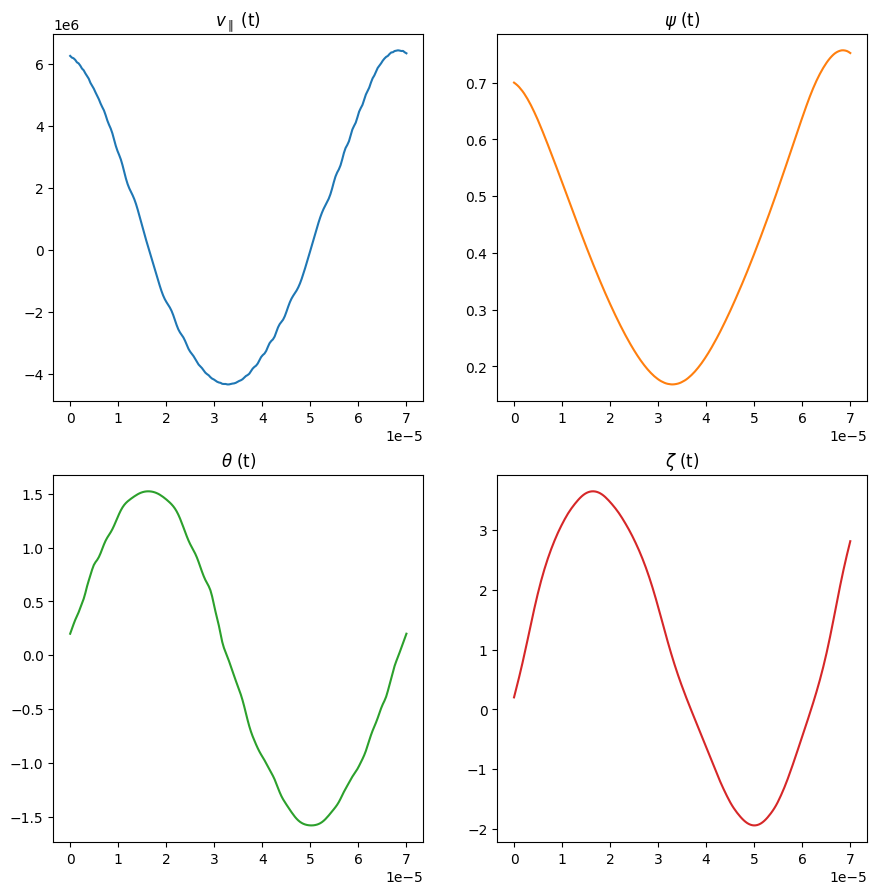

In [ ]:
t = np.linspace(t_i, t_f, nt_)
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(t, sol[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(t, sol[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(t, sol[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(t, sol[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

[6.34197411e+13]


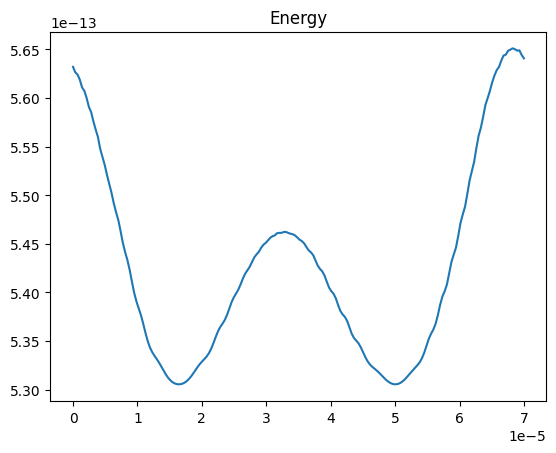

In [ ]:

grid = Grid(np.vstack((np.sqrt(psi_i), theta_i, zeta_i)).T,sort=False)
B_field = eq.compute("|B|", grid=grid)
Energy = 0.5*(sol[:, 3]**2 + 2*B_field["|B|"]*mu)*m_*1.673e-27
plt.plot(t, Energy)
plt.title("Energy")
print(mu)